In [ ]:
# ============================================================
# FEATURE EXTRACTION
# ============================================================
!pip -q install fer==22.5.0 transformers torchaudio librosa tqdm torchvggish soundfile

# ============================================================
# 📦 Imports
# ============================================================
import os
import pickle
import subprocess
import warnings

import cv2
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import torch
import torchaudio
from tqdm import tqdm
from fer import FER
from transformers import CLIPProcessor, CLIPModel, Wav2Vec2Processor, Wav2Vec2Model
from torchvggish import vggish, vggish_input



warnings.filterwarnings("ignore")

# ============================================================
# 📂 Paths & Config
# ============================================================
BASE_DIR = "/content/drive/MyDrive/NNDL"

FULL_ANNOT_CSV = os.path.join(BASE_DIR, "subset_annotations.pkl")   # your full annotation file
FULL_VIDEO_DIR = os.path.join(BASE_DIR, "train_subset_3k")          # folder with all videos

OUT_DIR = os.path.join(BASE_DIR, "Seq_features_CLIP_FER_W2V_VGGish")
os.makedirs(OUT_DIR, exist_ok=True)

# How many videos to use (first N from CSV)
MAX_VIDEOS = 1000

# Frame sampling: process every Nth frame
FRAME_STEP = 12      # larger = faster, fewer timesteps

# Audio segment length for Wav2Vec2 (seconds)
W2V_WINDOW_SEC = 0.5

print("📂 Video dir:", FULL_VIDEO_DIR)
print("📄 Annotation:", FULL_ANNOT_CSV)
print("💾 Output dir:", OUT_DIR)

# ============================================================
# 🧠 Load models
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Using device:", DEVICE)

# CLIP (vision)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
CLIP_DIM = clip_model.config.projection_dim  # 512

# FER (emotion)
emotion_detector = FER(mtcnn=True)  # 7 emotions

# Wav2Vec2 (audio)
wav2vec_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base").to(DEVICE)
W2V_DIM = wav2vec_model.config.hidden_size  # 768

# VGGish (audio)
vggish_model = vggish()
vggish_model.eval()
VGGISH_DIM = 128

# ============================================================
# 📑 Load annotations and choose first N videos
# ============================================================
# Correct way to load a .pkl (pickle) file
print(f"🔄 Loading annotations from pickle file: {FULL_ANNOT_CSV}")
with open(FULL_ANNOT_CSV, "rb") as f:
    df_data = pickle.load(f)

# Your original code was expecting a DataFrame.
# If the pickle file contains a dictionary or other data structure,
# you'll need to convert it to a DataFrame.
# Based on the original CSV snippets from a previous context,
# your `.pkl` might contain a DataFrame or a structure convertible to one.
# Assuming the pickle file contains the DataFrame directly:
df = df_data

# Make sure column names match your file
label_cols = ["openness", "conscientiousness", "extraversion", "agreeableness", "neuroticism"]

df = df.iloc[:MAX_VIDEOS].reset_index(drop=True)
video_list = df["video"].tolist()
labels = df[label_cols].values.astype(np.float32)

# ============================================================
# 🔊 Helper: extract audio with FFmpeg
# ============================================================
def load_audio_ffmpeg(video_path, sr=16000):
    """
    Extracts mono audio using FFmpeg and loads with soundfile.
    """
    try:
        wav_path = "/tmp/temp_audio.wav"
        cmd = [
            "ffmpeg", "-y",
            "-i", video_path,
            "-ac", "1",           # mono
            "-ar", str(sr),       # resample
            "-vn",                # no video
            wav_path
        ]
        subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        audio, sr = sf.read(wav_path)
        audio = audio.astype(np.float32)
        return audio, sr
    except Exception as e:
        print("❌ Audio FFmpeg error:", e)
        return None, None

# ============================================================
# 👁 Helper: CLIP embedding for a single frame
# ============================================================
def extract_clip_frame_embedding(frame_bgr):
    """
    frame_bgr: OpenCV BGR frame
    returns: (512,) CLIP embedding
    """
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    inputs = clip_processor(images=[frame_rgb], return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        feats = clip_model.get_image_features(**inputs)  # (1, 512)
    return feats[0].cpu().numpy()

# ============================================================
# 😊 Helper: FER emotion (7D) for a single frame
# ============================================================
def extract_fer_emotion(frame_bgr):
    """
    Returns 7D emotion vector (in fixed order).
    If detection fails, returns zeros.
    """
    try:
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        detections = emotion_detector.detect_emotions(frame_rgb)
        if not detections:
            return np.zeros(7, dtype=np.float32)
        # emotions is a dict: {'angry':.., 'disgust':.., ...}
        emo_dict = detections[0]["emotions"]
        # enforce consistent ordering
        keys = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]
        return np.array([emo_dict[k] for k in keys], dtype=np.float32)
    except:
        return np.zeros(7, dtype=np.float32)

# ============================================================
# 🔊 Helper: Wav2Vec2 segment embedding
# ============================================================
def extract_wav2vec2_segment(audio, sr, t_sec, win_sec=0.5):
    """
    Extracts a short segment around t_sec and returns Wav2Vec2 embedding (768,).
    """
    try:
        half = int(sr * win_sec / 2)
        center = int(t_sec * sr)
        start = max(0, center - half)
        end   = min(len(audio), center + half)
        if end <= start:
            return np.zeros(W2V_DIM, dtype=np.float32)

        segment = audio[start:end]

        with torch.no_grad():
            inputs = wav2vec_processor(segment, sampling_rate=sr, return_tensors="pt")
            outputs = wav2vec_model(inputs.input_values.to(DEVICE))
            emb = outputs.last_hidden_state.mean(dim=1)[0].cpu().numpy()
        return emb.astype(np.float32)
    except Exception as e:
        # print("Wav2Vec2 error:", e)
        return np.zeros(W2V_DIM, dtype=np.float32)

# ============================================================
# 🎧 Helper: VGGish global audio embedding
# ============================================================
def extract_vggish_global(audio, sr):
    """
    Compute VGGish embeddings over entire audio, then mean-pool.
    Returns 128-D vector.
    """
    try:
        # VGGish expects mono 16k waveform in [-1, 1]
        if sr != 16000:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
            sr = 16000

        examples = vggish_input.waveform_to_examples(audio, sr)  # (N, 96, 64)
        if examples.shape[0] == 0:
            return np.zeros(VGGISH_DIM, dtype=np.float32)

        examples_t = torch.from_numpy(examples).unsqueeze(1)  # (N,1,96,64)
        with torch.no_grad():
            emb = vggish_model(examples_t)  # (N,128)
        emb = emb.mean(dim=0).cpu().numpy()
        return emb.astype(np.float32)
    except Exception as e:
        # print("VGGish error:", e)
        return np.zeros(VGGISH_DIM, dtype=np.float32)

# ============================================================
# 💾 Checkpoint paths
# ============================================================
seq_X_partial_path = os.path.join(OUT_DIR, "seq_X_partial.pkl")
seq_y_partial_path = os.path.join(OUT_DIR, "seq_y_partial.pkl")
seq_id_partial_path = os.path.join(OUT_DIR, "seq_id_partial.pkl")

# ============================================================
# 🔁 Load checkpoint if exists
# ============================================================
final_id_path = os.path.join(OUT_DIR, "seq_id.npy")
if os.path.exists(seq_X_partial_path):
    print("🔁 Resuming from checkpoint...")
    with open(seq_X_partial_path, "rb") as f:
        seq_X_list = pickle.load(f)
    with open(seq_y_partial_path, "rb") as f:
        seq_y_list = pickle.load(f)
    with open(seq_id_partial_path, "rb") as f:
        seq_id_list = pickle.load(f)


    processed_set = set(seq_id_list)
else:
    seq_X_list = []
    seq_y_list = []
    seq_id_list = []
    processed_set = set()

print(f"🔹 Already processed videos: {len(processed_set)}")

# ============================================================
# 🎬 Main extraction loop
# ============================================================
for idx, (vid_name, y) in enumerate(tqdm(zip(video_list, labels), total=len(video_list))):

    if vid_name in processed_set:
        continue

    video_path = os.path.join(FULL_VIDEO_DIR, vid_name)
    if not os.path.exists(video_path):
        print("❌ Missing video:", video_path)
        continue

    print(f"\n▶ [{idx+1}/{len(video_list)}] Processing:", vid_name)

    # -------------------- AUDIO --------------------
    audio, sr = load_audio_ffmpeg(video_path, sr=16000)
    if audio is None:
        print("❌ Skipping (audio extract failed)")
        continue

    # Global VGGish for entire audio
    vggish_emb = extract_vggish_global(audio, sr)  # (128,)

    # -------------------- VIDEO --------------------
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 0:
        fps = 25.0

    frame_features = []

    fidx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if fidx % FRAME_STEP != 0:
            fidx += 1
            continue

        t_sec = fidx / fps

        # Vision: CLIP + FER
        clip_emb = extract_clip_frame_embedding(frame)  # (512,)
        fer_emb  = extract_fer_emotion(frame)          # (7,)

        # Audio: Wav2Vec2 for this time
        w2v_emb  = extract_wav2vec2_segment(audio, sr, t_sec, win_sec=W2V_WINDOW_SEC)  # (768,)

        # Repeat global VGGish for this timestep
        vgg_emb_t = vggish_emb  # (128,)

        # concat: [CLIP, FER, W2V2, VGGish] → 512+7+768+128 = 1415
        feat_t = np.concatenate([clip_emb, fer_emb, w2v_emb, vgg_emb_t], axis=0)
        frame_features.append(feat_t)

        fidx += 1

    cap.release()

    if len(frame_features) == 0:
        print("⚠ No frames/features extracted, skipping video:", vid_name)
        continue

    seq_feats = np.stack(frame_features, axis=0)  # (T, 1415)

    # -------------------- Store --------------------
    seq_X_list.append(seq_feats)
    seq_y_list.append(y)
    seq_id_list.append(vid_name)
    processed_set.add(vid_name)

    # -------------------- Save checkpoint every 10 videos processed --------------------
    if len(seq_id_list) % 10 == 0:
        print(f"💾 Saving checkpoint at {len(seq_id_list)} videos...")
        with open(seq_X_partial_path, "wb") as f:
            pickle.dump(seq_X_list, f)
        with open(seq_y_partial_path, "wb") as f:
            pickle.dump(seq_y_list, f)
        with open(seq_id_partial_path, "wb") as f:
            pickle.dump(seq_id_list, f)

# ============================================================
# ✅ Save final outputs as .npy
# ============================================================
print("\n🎉 Extraction complete. Saving final arrays...")

seq_X = np.array(seq_X_list, dtype=object)   # list of (T_i, 1415)
seq_y = np.array(seq_y_list, dtype=np.float32)  # (N,5)
seq_id = np.array(seq_id_list)

np.save(os.path.join(OUT_DIR, "seq_X.npy"), seq_X, allow_pickle=True)
np.save(os.path.join(OUT_DIR, "seq_y.npy"), seq_y)
np.save(os.path.join(OUT_DIR, "seq_id.npy"), seq_id)

print("✅ Saved:")
print("  seq_X.npy shape:", seq_X.shape)
print("  seq_y.npy shape:", seq_y.shape)
print("  seq_id.npy shape:", seq_id.shape)

# Remove partial checkpoints
for p in [seq_X_partial_path, seq_y_partial_path, seq_id_partial_path]:
    if os.path.exists(p):
        os.remove(p)

print("\n🧹 Checkpoints cleaned. All done!")

Loading NumPy feature files (.npy)...
✅ Loaded 500 videos
Example X shape: (39, 1415)
Example y: [0.36666667 0.5825243  0.34579438 0.47252747 0.375     ]
Example id: zEyRyTnIw5I.005.mp4
Train: 350 | Val: 75 | Test: 75
Using: cpu
Epoch 1 | Train 0.0505 | Val 0.0206 | MSE 0.0206 | MAE 0.1145 | R² -0.0275 | Acc±0.1 50.13%
Epoch 2 | Train 0.0324 | Val 0.0185 | MSE 0.0186 | MAE 0.1087 | R² 0.0852 | Acc±0.1 51.47%
Epoch 3 | Train 0.0254 | Val 0.0199 | MSE 0.0204 | MAE 0.1160 | R² -0.0270 | Acc±0.1 49.07%
Epoch 4 | Train 0.0238 | Val 0.0149 | MSE 0.0150 | MAE 0.0987 | R² 0.2560 | Acc±0.1 57.87%
Epoch 5 | Train 0.0215 | Val 0.0155 | MSE 0.0153 | MAE 0.1002 | R² 0.2348 | Acc±0.1 56.53%
Epoch 6 | Train 0.0189 | Val 0.0197 | MSE 0.0203 | MAE 0.1163 | R² -0.0032 | Acc±0.1 49.33%
Epoch 7 | Train 0.0176 | Val 0.0157 | MSE 0.0159 | MAE 0.1029 | R² 0.2137 | Acc±0.1 54.13%
Epoch 8 | Train 0.0181 | Val 0.0186 | MSE 0.0189 | MAE 0.1121 | R² 0.0704 | Acc±0.1 51.20%
Epoch 9 | Train 0.0157 | Val 0.0175 | MS

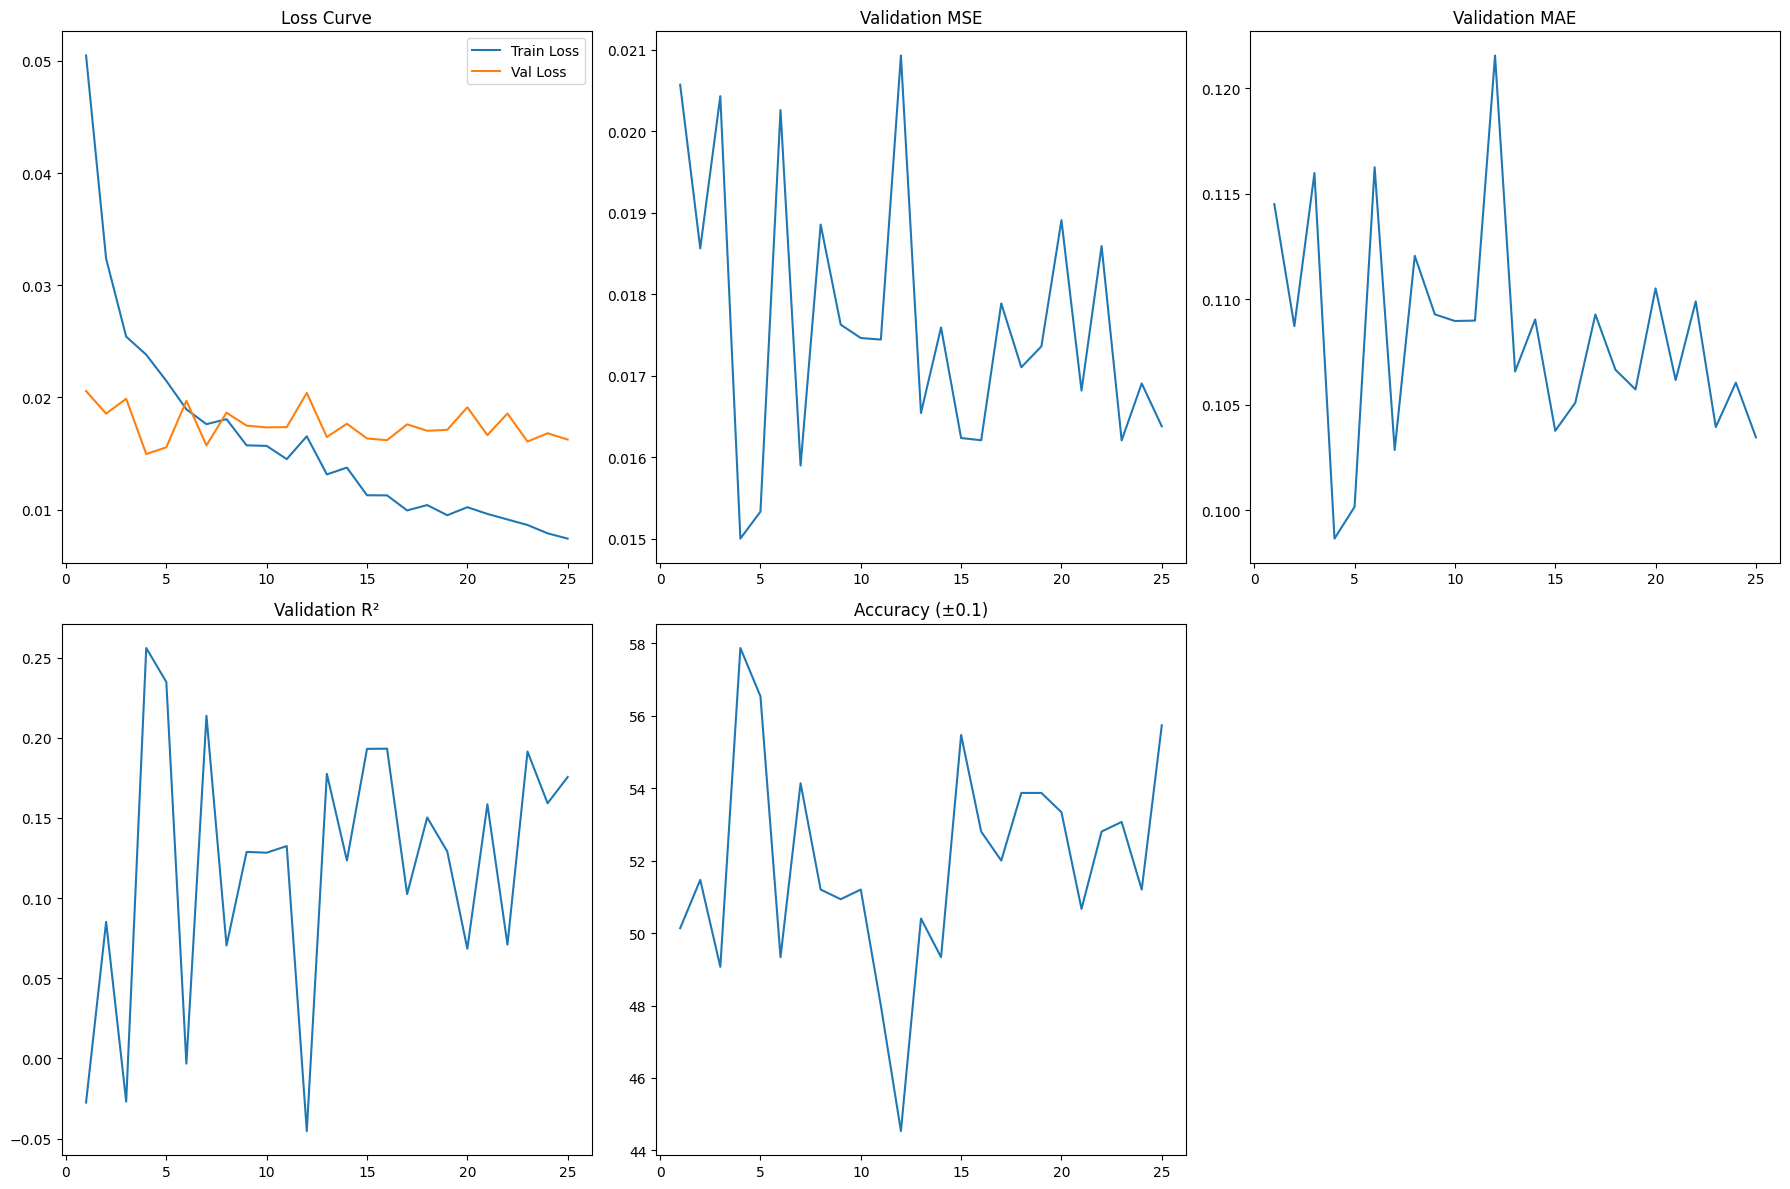


================= FINAL TEST RESULTS =================
MSE: 0.0123
MAE: 0.0894
R²: 0.2737
Accuracy ±0.1: 61.07%


In [ ]:
#===================================================
#  1D TRANSFORMER

# ============================================================
# 📦 Install & Imports
# ============================================================
!pip install -q scikit-learn

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# ============================================================
# 📂 Paths
# ============================================================
FEATURE_DIR = "/content/drive/MyDrive/NNDL/Seq_features_CLIP_FER_W2V_VGGish"
MODEL_SAVE_PATH = "/content/drive/MyDrive/NNDL/ocean_enc_bigru_transformer_best.pth" # Path for saving the best model

seq_X_path = os.path.join(FEATURE_DIR, "seq_X.npy")
seq_y_path = os.path.join(FEATURE_DIR, "seq_y.npy")
seq_id_path = os.path.join(FEATURE_DIR, "seq_id.npy")

print("Loading NumPy feature files (.npy)...")

# np.load is the correct function for .npy files
seq_X_raw = np.load(seq_X_path, allow_pickle=True)
seq_y = np.load(seq_y_path)
seq_id = np.load(seq_id_path)

# Convert to proper types
seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
seq_y = np.array(seq_y, dtype=np.float32)
seq_id = np.array(seq_id)

N = len(seq_X)
INPUT_DIM = seq_X[0].shape[1]

print(f"✅ Loaded {N} videos")
print("Example X shape:", seq_X[0].shape)
print("Example y:", seq_y[0])
print("Example id:", seq_id[0])


# ============================================================
# 🧾 Dataset + Collate
# ============================================================
class OceanDataset(Dataset):
    def __init__(self, X_list, y_array, ids):
        self.X_list = X_list
        self.y_array = y_array
        self.ids = ids

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        return {
            "x": torch.tensor(self.X_list[idx], dtype=torch.float32),
            "y": torch.tensor(self.y_array[idx], dtype=torch.float32),
            "id": self.ids[idx],
        }

def collate_fn(batch):
    xs = [item["x"] for item in batch]
    ys = [item["y"] for item in batch]
    ids = [item["id"] for item in batch]

    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    feat_dim = xs[0].shape[1]
    B = len(xs)

    padded_x = torch.zeros(B, max_len, feat_dim)
    mask = torch.zeros(B, max_len)

    for i, x in enumerate(xs):
        T = x.shape[0]
        padded_x[i, :T] = x
        mask[i, :T] = 1

    y = torch.stack(ys, dim=0)
    return {"x": padded_x, "y": y, "mask": mask, "id": ids}

dataset = OceanDataset(seq_X, seq_y, seq_id)

# ============================================================
# 📊 Train / Val / Test Split
# ============================================================
train_size = int(0.7 * N)
val_size = int(0.15 * N)
test_size = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


# ============================================================
# 🧠 Conv1D + Transformer Model
# ============================================================
class OceanConvTransformer(nn.Module):
    def __init__(self, input_dim=1291, d_model=256, nhead=8,
                 num_layers=3, dim_feedforward=512, dropout=0.2):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)

        # Local temporal modeling
        self.conv = nn.Sequential(
            nn.Conv1d(d_model, d_model, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(d_model, d_model, 3, padding=1),
            nn.ReLU(),
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 5),
        )

    def forward(self, x, mask):
        B, T, _ = x.shape

        x = self.input_proj(x)

        x = x.permute(0, 2, 1) # (B, T, D) -> (B, D, T) for Conv1D
        x = self.conv(x)
        x = x.permute(0, 2, 1) # (B, D, T) -> (B, T, D) for Transformer

        cls_tok = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls_tok, x], dim=1)

        cls_mask = torch.ones(B, 1, device=mask.device)
        full_mask = torch.cat([cls_mask, mask], dim=1)
        key_mask = (full_mask == 0) # True where pad

        x = self.encoder(x, src_key_padding_mask=key_mask)
        cls_out = x[:, 0]
        return self.head(cls_out)


# ============================================================
# 📏 Metrics
# ============================================================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    acc = ((np.abs(y_true - y_pred) <= 0.1).mean()) * 100
    return mse, mae, r2, acc


# ============================================================
# 📈 Store Metrics for Graph Plotting
# ============================================================
train_loss_history = []
val_loss_history = []

val_mse_history = []
val_mae_history = []
val_r2_history = []
val_acc_history = []


# ============================================================
# 🏋️ Training Loop
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

model = OceanConvTransformer(input_dim=INPUT_DIM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

best_val = float("inf")
# ADDED: Initialize best_state to save the best model weights
best_state = model.state_dict()
patience = 5
pat_ctr = 0
EPOCHS = 25

for epoch in range(1, EPOCHS + 1):
    # -------- TRAIN --------
    model.train()
    train_losses = []

    for batch in train_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        optimizer.zero_grad()
        preds = model(x, mask)

        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train = np.mean(train_losses)
    train_loss_history.append(avg_train)

    # -------- VALIDATION --------
    model.eval()
    val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

            preds = model(x, mask)
            loss = criterion(preds, y)
            val_losses.append(loss.item())

            y_true.append(y.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    avg_val = np.mean(val_losses)
    val_loss_history.append(avg_val)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    mse, mae, r2, acc = compute_metrics(y_true, y_pred)

    val_mse_history.append(mse)
    val_mae_history.append(mae)
    val_r2_history.append(r2)
    val_acc_history.append(acc)

    print(f"Epoch {epoch} | Train {avg_train:.4f} | Val {avg_val:.4f} | "
          f"MSE {mse:.4f} | MAE {mae:.4f} | R² {r2:.4f} | Acc±0.1 {acc:.2f}%")



# Load the best model state before final test/save
model.load_state_dict(best_state)

# ============================================================
# 💾 SAVE FINAL MODEL
# ============================================================
# ADDED: Save the best model state to the specified path
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"✅ Best model state saved to: {MODEL_SAVE_PATH}")

# ============================================================
# 📈 PLOT GRAPHS
# ============================================================
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(18, 12))

# Loss
plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.plot(epochs, val_loss_history, label="Val Loss")
plt.title("Loss Curve")
plt.legend()

# MSE
plt.subplot(2, 3, 2)
plt.plot(epochs, val_mse_history)
plt.title("Validation MSE")

# MAE
plt.subplot(2, 3, 3)
plt.plot(epochs, val_mae_history)
plt.title("Validation MAE")

# R²
plt.subplot(2, 3, 4)
plt.plot(epochs, val_r2_history)
plt.title("Validation R²")

# Accuracy
plt.subplot(2, 3, 5)
plt.plot(epochs, val_acc_history)
plt.title("Accuracy (±0.1)")

plt.tight_layout()
plt.show()


# ============================================================
# 🧪 FINAL TEST EVALUATION
# ============================================================
model.eval()
true_list, pred_list = [], []

with torch.no_grad():
    for batch in test_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
        preds = model(x, mask)
        true_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())

true_list = np.vstack(true_list)
pred_list = np.vstack(pred_list)

mse, mae, r2, acc = compute_metrics(true_list, pred_list)

print("\n================= FINAL TEST RESULTS =================")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"Accuracy ±0.1: {acc:.2f}%")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading NumPy feature files (.npy)...
✅ Loaded 500 videos
Example X shape: (39, 1415)
Example y: [0.36666667 0.5825243  0.34579438 0.47252747 0.375     ]
Example id: zEyRyTnIw5I.005.mp4
Train: 350 | Val: 75 | Test: 75
Using: cpu
Epoch 1 | Train 0.0529 | Val 0.0259 | MSE 0.0242 | MAE 0.1198 | R² -0.0343 | Acc±0.1 49.33%
Epoch 2 | Train 0.0299 | Val 0.0192 | MSE 0.0183 | MAE 0.1091 | R² 0.2186 | Acc±0.1 54.67%
Epoch 3 | Train 0.0265 | Val 0.0195 | MSE 0.0184 | MAE 0.1073 | R² 0.2113 | Acc±0.1 56.27%
Epoch 4 | Train 0.0209 | Val 0.0180 | MSE 0.0180 | MAE 0.1086 | R² 0.2340 | Acc±0.1 53.87%
Epoch 5 | Train 0.0207 | Val 0.0196 | MSE 0.0191 | MAE 0.1096 | R² 0.1786 | Acc±0.1 53.60%
Epoch 6 | Train 0.0186 | Val 0.0170 | MSE 0.0171 | MAE 0.1054 | R² 0.2684 | Acc±0.1 54.40%
Epoch 7 | Train 0.0170 | Val 0.0169 | MSE 0.0169 | MAE 0.1040 | R² 0.2755 | Acc±0.1 53.07%
Epoc

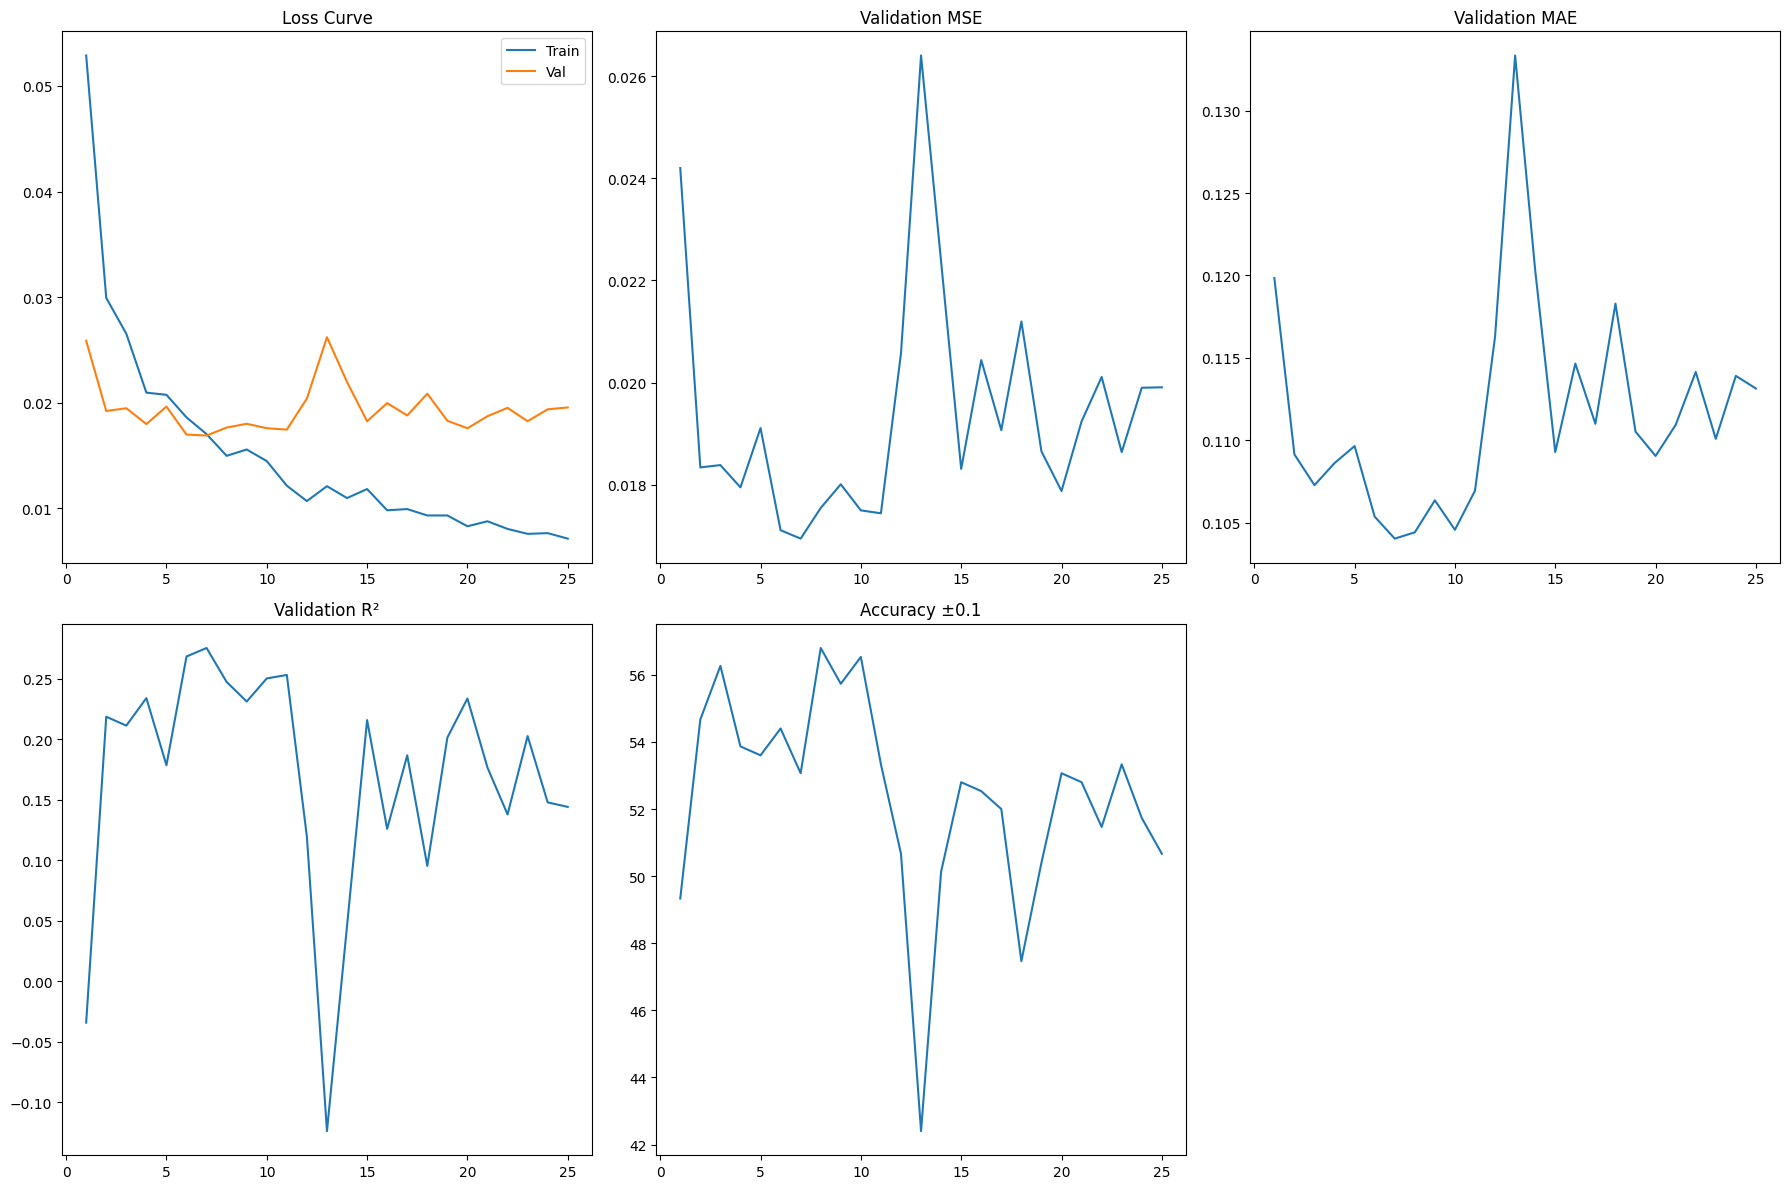


================= FINAL TEST RESULTS =================
MSE: 0.0199
MAE: 0.1131
R²: -0.1533
Accuracy ±0.1: 50.13%


In [ ]:
# ============================================================
#                            HCAFT
# ============================================================
# 📦 Install & Imports
# ============================================================
!pip install -q scikit-learn

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from google.colab import drive
drive.mount('/content/drive')


# ============================================================
# 📂 Paths
# ============================================================
FEATURE_DIR = "/content/drive/MyDrive/NNDL/Seq_features_CLIP_FER_W2V_VGGish"
MODEL_SAVE_PATH = "/content/drive/MyDrive/NNDL/ocean_enc_bigru_transformer_best.pth" # Path for saving the best model

seq_X_path = os.path.join(FEATURE_DIR, "seq_X.npy")
seq_y_path = os.path.join(FEATURE_DIR, "seq_y.npy")
seq_id_path = os.path.join(FEATURE_DIR, "seq_id.npy")

print("Loading NumPy feature files (.npy)...")

# np.load is the correct function for .npy files
seq_X_raw = np.load(seq_X_path, allow_pickle=True)
seq_y = np.load(seq_y_path)
seq_id = np.load(seq_id_path)

# Convert to correct types
seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
seq_y = np.array(seq_y, dtype=np.float32)
seq_id = np.array(seq_id)

N = len(seq_X)
INPUT_DIM = seq_X[0].shape[1]

print(f"✅ Loaded {N} videos")
print("Example X shape:", seq_X[0].shape)
print("Example y:", seq_y[0])
print("Example id:", seq_id[0])


# ============================================================
# 🧾 Dataset + Collate
# ============================================================
class OceanDataset(Dataset):
    def __init__(self, X_list, y_array, ids):
        self.X_list = X_list
        self.y_array = y_array
        self.ids = ids

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        return {
            "x": torch.tensor(self.X_list[idx], dtype=torch.float32),
            "y": torch.tensor(self.y_array[idx], dtype=torch.float32),
            "id": self.ids[idx],
        }

def collate_fn(batch):
    xs = [item["x"] for item in batch]
    ys = [item["y"] for item in batch]
    ids = [item["id"] for item in batch]

    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    feat_dim = xs[0].shape[1]
    B = len(xs)

    padded_x = torch.zeros(B, max_len, feat_dim)
    mask = torch.zeros(B, max_len)

    for i, x in enumerate(xs):
        T = x.shape[0]
        padded_x[i, :T] = x
        mask[i, :T] = 1

    y = torch.stack(ys, dim=0)
    return {"x": padded_x, "y": y, "mask": mask, "id": ids}

dataset = OceanDataset(seq_X, seq_y, seq_id)


# ============================================================
# 📊 Train / Val / Test Split
# ============================================================
train_size = int(0.7 * N)
val_size = int(0.15 * N)
test_size = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


# ============================================================
# 🧠 HCAFT: Encoders + Cross-Attention + BiGRU + Transformer
# ============================================================
class CrossAttentionBlock(nn.Module):
    """
    Simple cross-attention block:
    Q attends to K,V using MultiheadAttention.
    """
    def __init__(self, dim, nhead=4, dropout=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=dim, num_heads=nhead, dropout=dropout, batch_first=True)
        self.ln = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.ReLU(),
            nn.Linear(dim * 2, dim),
        )
        self.ff_ln = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, key_padding_mask=None):
        # q,k,v: (B, T, dim)
        attn_out, _ = self.mha(q, k, v, key_padding_mask=key_padding_mask)
        x = self.ln(q + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.ff_ln(x + self.dropout(ff_out))
        return x


class OceanHCAFT(nn.Module):
    def __init__(
        self,
        input_dim=1291,
        clip_dim=512,
        fer_dim=7,
        wav_dim=768,
        prosody_dim=4,
        clip_enc_dim=128,
        fer_enc_dim=32,
        wav_enc_dim=128,
        prosody_enc_dim=16,
        d_model=256,
        nhead_xattn=4,
        nhead_transformer=8,
        num_layers_transformer=2,
        dim_feedforward=512,
        dropout=0.2,
    ):
        super().__init__()

        self.clip_dim = clip_dim
        self.fer_dim = fer_dim
        self.wav_dim = wav_dim
        self.prosody_dim = prosody_dim

        # -------------------------
        # 🔹 1. Modality Encoders (frame-level)
        # -------------------------
        self.clip_encoder = nn.Sequential(
            nn.Linear(clip_dim, clip_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(clip_enc_dim),
        )

        self.fer_encoder = nn.Sequential(
            nn.Linear(fer_dim, fer_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(fer_enc_dim),
        )

        self.wav_encoder = nn.Sequential(
            nn.Linear(wav_dim, wav_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(wav_enc_dim),
        )

        self.prosody_encoder = nn.Sequential(
            nn.Linear(prosody_dim, prosody_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(prosody_enc_dim),
        )

        # Ensure the sum of output dimensions is consistent with the projection
        fused_dim = clip_enc_dim + wav_enc_dim + fer_enc_dim + prosody_enc_dim

        # -------------------------
        # 🔹 2. Cross-Attention Fusion (frame-level)
        # -------------------------
        self.cross_clip_from_audio = CrossAttentionBlock(clip_enc_dim, nhead=nhead_xattn, dropout=dropout)
        self.cross_audio_from_clip = CrossAttentionBlock(wav_enc_dim, nhead=nhead_xattn, dropout=dropout)

        self.fuse_proj = nn.Sequential(
            nn.Linear(fused_dim, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
        )

        # -------------------------
        # 🔹 3. BiGRU (segment / local temporal modeling)
        # -------------------------
        self.bigru = nn.GRU(
            input_size=d_model,
            hidden_size=d_model // 2,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.gru_ln = nn.LayerNorm(d_model)

        # -------------------------
        # 🔹 4. Video-level Transformer
        # -------------------------
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead_transformer,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers_transformer)

        # -------------------------
        # 🔹 5. OCEAN Regression Head
        # -------------------------
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 5),  # O, C, E, A, N
        )

    def forward(self, x, mask):
        """
        x: (B, T, 1291)
        mask: (B, T) with 1 for valid, 0 for padded
        """
        B, T, D = x.shape

        # -------------------------
        # Split modalities
        # -------------------------
        x_clip = x[:, :, 0:self.clip_dim]
        x_fer = x[:, :, self.clip_dim:self.clip_dim + self.fer_dim]
        x_wav = x[:, :, self.clip_dim + self.fer_dim:self.clip_dim + self.fer_dim + self.wav_dim]
        x_pros = x[:, :, -self.prosody_dim:]

        # -------------------------
        # Frame-level encoding
        # -------------------------
        e_clip = self.clip_encoder(x_clip)
        e_fer = self.fer_encoder(x_fer)
        e_wav = self.wav_encoder(x_wav)
        e_pros = self.prosody_encoder(x_pros)

        # -------------------------
        # Cross-Attention: CLIP ↔ Audio
        # -------------------------
        key_padding = (mask == 0)

        # CLIP attends to Audio
        clip_from_audio = self.cross_clip_from_audio(
            q=e_clip, k=e_wav, v=e_wav, key_padding_mask=key_padding
        )

        # Audio attends to CLIP
        audio_from_clip = self.cross_audio_from_clip(
            q=e_wav, k=e_clip, v=e_clip, key_padding_mask=key_padding
        )

        # Fuse all enriched features
        fused = torch.cat(
            [clip_from_audio, audio_from_clip, e_fer, e_pros],
            dim=-1
        )

        fused = self.fuse_proj(fused)

        # -------------------------
        # BiGRU for local temporal modeling
        # -------------------------
        gru_out, _ = self.bigru(fused)
        gru_out = self.gru_ln(gru_out)

        # -------------------------
        # Video-level Transformer with [CLS]
        # -------------------------
        cls_tok = self.cls_token.expand(B, 1, -1)
        seq = torch.cat([cls_tok, gru_out], dim=1)

        cls_mask = torch.ones(B, 1, device=mask.device)
        full_mask = torch.cat([cls_mask, mask], dim=1)
        key_padding_mask = (full_mask == 0)

        enc = self.encoder(seq, src_key_padding_mask=key_padding_mask)
        cls_out = enc[:, 0]

        # -------------------------
        # OCEAN prediction
        # -------------------------
        out = self.head(cls_out)
        return out


# ============================================================
# 📏 Metrics
# ============================================================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    acc = ((np.abs(y_true - y_pred) <= 0.1).mean()) * 100
    return mse, mae, r2, acc


# ============================================================
# 📈 Training Setup
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

model = OceanHCAFT(input_dim=INPUT_DIM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

train_loss_history = []
val_loss_history = []

val_mse_history = []
val_mae_history = []
val_r2_history = []
val_acc_history = []

best_val = float("inf")
best_state = model.state_dict() # Initialize best_state for saving
patience = 5
pat_ctr = 0
EPOCHS = 25

# ============================================================
# 🏋️ Training Loop
# ============================================================
for epoch in range(1, EPOCHS + 1):

    # -------- TRAIN --------
    model.train()
    train_losses = []

    for batch in train_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        optimizer.zero_grad()
        preds = model(x, mask)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train = np.mean(train_losses)
    train_loss_history.append(avg_train)

    # -------- VALIDATION --------
    model.eval()
    val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
            preds = model(x, mask)

            loss = criterion(preds, y)
            val_losses.append(loss.item())

            y_true.append(y.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    avg_val = np.mean(val_losses)
    val_loss_history.append(avg_val)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    mse, mae, r2, acc = compute_metrics(y_true, y_pred)

    val_mse_history.append(mse)
    val_mae_history.append(mae)
    val_r2_history.append(r2)
    val_acc_history.append(acc)

    print(f"Epoch {epoch} | Train {avg_train:.4f} | Val {avg_val:.4f} | "
          f"MSE {mse:.4f} | MAE {mae:.4f} | R² {r2:.4f} | Acc±0.1 {acc:.2f}%")



# Load the best model state dictionary before final test/save
model.load_state_dict(best_state)


# ============================================================
# 💾 Save Final Model
# ============================================================
torch.save(model.state_dict(), MODEL_SAVE_PATH) # 🔑 FINAL SAVE COMMAND
print(f"✅ Best model state saved to: {MODEL_SAVE_PATH}")


# ============================================================
# 📈 Plot Metrics
# ============================================================
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss_history, label="Train")
plt.plot(epochs, val_loss_history, label="Val")
plt.title("Loss Curve")
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, val_mse_history)
plt.title("Validation MSE")

plt.subplot(2, 3, 3)
plt.plot(epochs, val_mae_history)
plt.title("Validation MAE")

plt.subplot(2, 3, 4)
plt.plot(epochs, val_r2_history)
plt.title("Validation R²")

plt.subplot(2, 3, 5)
plt.plot(epochs, val_acc_history)
plt.title("Accuracy ±0.1")

plt.tight_layout()
plt.show()


# ============================================================
# 🧪 Final Test Evaluation
# ============================================================
model.eval()
true_list, pred_list = [], []

with torch.no_grad():
    for batch in test_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
        preds = model(x, mask)
        true_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())

true_list = np.vstack(true_list)
pred_list = np.vstack(pred_list)

mse, mae, r2, acc = compute_metrics(true_list, pred_list)

print("\n================= FINAL TEST RESULTS =================")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"Accuracy ±0.1: {acc:.2f}%")

Loading NumPy feature files (.npy)...
✅ Loaded 500 videos
Example X shape: (39, 1415)
Example y: [0.36666667 0.5825243  0.34579438 0.47252747 0.375     ]
Example id: zEyRyTnIw5I.005.mp4
Train: 350 | Val: 75 | Test: 75
Using: cpu
Epoch 1 | Train 0.0525 | Val 0.0182 | MSE 0.0184 | MAE 0.1094 | R² -0.0386 | Acc±0.1 51.73%
Epoch 2 | Train 0.0284 | Val 0.0147 | MSE 0.0152 | MAE 0.0983 | R² 0.1470 | Acc±0.1 58.13%
Epoch 3 | Train 0.0237 | Val 0.0147 | MSE 0.0151 | MAE 0.0973 | R² 0.1446 | Acc±0.1 61.33%
Epoch 4 | Train 0.0201 | Val 0.0132 | MSE 0.0137 | MAE 0.0936 | R² 0.2284 | Acc±0.1 60.00%
Epoch 5 | Train 0.0202 | Val 0.0135 | MSE 0.0140 | MAE 0.0955 | R² 0.2193 | Acc±0.1 59.47%
Epoch 6 | Train 0.0166 | Val 0.0139 | MSE 0.0144 | MAE 0.0967 | R² 0.1978 | Acc±0.1 58.13%
Epoch 7 | Train 0.0168 | Val 0.0147 | MSE 0.0149 | MAE 0.0971 | R² 0.1582 | Acc±0.1 59.47%
Epoch 8 | Train 0.0149 | Val 0.0140 | MSE 0.0142 | MAE 0.0963 | R² 0.2032 | Acc±0.1 57.07%
Epoch 9 | Train 0.0150 | Val 0.0161 | MSE 

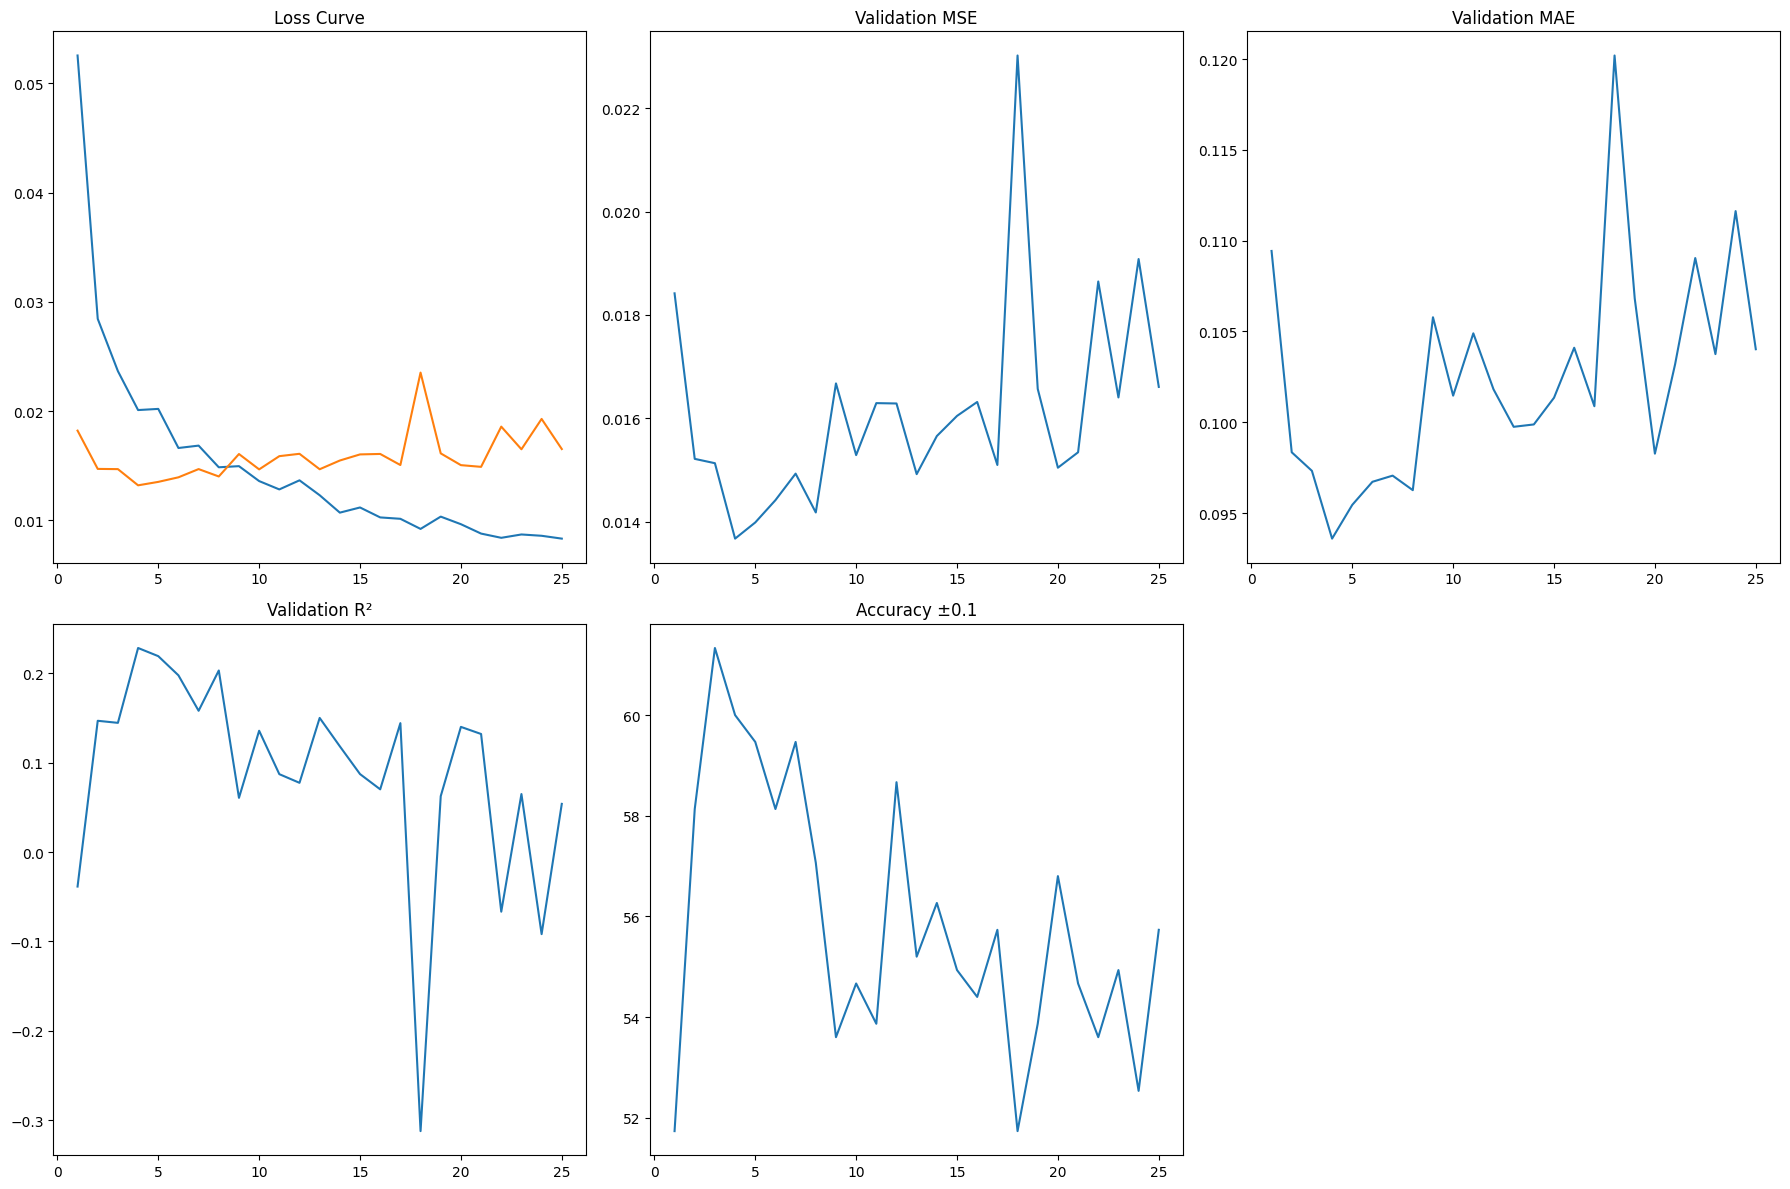


================= FINAL TEST RESULTS =================
MSE: 0.0073
MAE: 0.0692
R²:  0.6617
Accuracy ±0.1: 77.33%


In [ ]:
#=======================================
#    (gru + encoder + transformer)
#=========================================
# ============================================================
# 📦 Install & Imports   (gru + encoder + transformer)
# ============================================================
!pip install -q scikit-learn

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# ============================================================
# 📂 Paths
# ============================================================
FEATURE_DIR = "/content/drive/MyDrive/NNDL/Seq_features_CLIP_FER_W2V_VGGish"

seq_X_path  = os.path.join(FEATURE_DIR, "seq_X.npy")
seq_y_path  = os.path.join(FEATURE_DIR, "seq_y.npy")
seq_id_path = os.path.join(FEATURE_DIR, "seq_id.npy")

print("Loading NumPy feature files (.npy)...")

# np.load is the correct function for .npy files
# seq_X_raw is an array of objects (variable-length sequences), so allow_pickle=True is needed.
seq_X_raw = np.load(seq_X_path, allow_pickle=True)
seq_y = np.load(seq_y_path)
seq_id = np.load(seq_id_path)

# Convert to correct types
seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
seq_y = np.array(seq_y, dtype=np.float32)
seq_id = np.array(seq_id)

N = len(seq_X)
INPUT_DIM = seq_X[0].shape[1]

print(f"✅ Loaded {N} videos")
print("Example X shape:", seq_X[0].shape)
print("Example y:", seq_y[0])
print("Example id:", seq_id[0])


# ============================================================
# 🧾 Dataset + Collate
# ============================================================
class OceanDataset(Dataset):
    def __init__(self, X_list, y_array, ids):
        self.X_list = X_list
        self.y_array = y_array
        self.ids = ids

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        return {
            "x": torch.tensor(self.X_list[idx], dtype=torch.float32),
            "y": torch.tensor(self.y_array[idx], dtype=torch.float32),
            "id": self.ids[idx],
        }

def collate_fn(batch):
    xs  = [item["x"] for item in batch]
    ys  = [item["y"] for item in batch]
    ids = [item["id"] for item in batch]

    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    feat_dim = xs[0].shape[1]
    B = len(xs)

    padded_x = torch.zeros(B, max_len, feat_dim)
    mask = torch.zeros(B, max_len)

    for i, x in enumerate(xs):
        T = x.shape[0]
        padded_x[i, :T] = x
        mask[i, :T] = 1

    y = torch.stack(ys, dim=0)
    return {"x": padded_x, "y": y, "mask": mask, "id": ids}

dataset = OceanDataset(seq_X, seq_y, seq_id)


# ============================================================
# 📊 Train / Val / Test Split
# ============================================================
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


# ============================================================
# 🧠 Encoders + BiGRU + Transformer Model
# ============================================================
class OceanEncBiGRUTransformer(nn.Module):
    def __init__(
        self,
        input_dim=1291,
        clip_dim=512,
        fer_dim=7,
        wav_dim=768,
        prosody_dim=4,
        clip_enc_dim=128,
        fer_enc_dim=32,
        wav_enc_dim=128,
        prosody_enc_dim=16,
        d_model=256,
        nhead=8,
        num_layers=2,
        dim_feedforward=512,
        dropout=0.2,
    ):
        super().__init__()

        self.clip_dim = clip_dim
        self.fer_dim = fer_dim
        self.wav_dim = wav_dim
        self.prosody_dim = prosody_dim

        # -------------------------
        # 🔹 Modality Encoders
        # -------------------------
        self.clip_encoder = nn.Sequential(
            nn.Linear(clip_dim, clip_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(clip_enc_dim),
        )

        self.fer_encoder = nn.Sequential(
            nn.Linear(fer_dim, fer_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(fer_enc_dim),
        )

        self.wav_encoder = nn.Sequential(
            nn.Linear(wav_dim, wav_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(wav_enc_dim),
        )

        self.prosody_encoder = nn.Sequential(
            nn.Linear(prosody_dim, prosody_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(prosody_enc_dim),
        )

        fused_dim = clip_enc_dim + fer_enc_dim + wav_enc_dim + prosody_enc_dim

        self.fuse_proj = nn.Sequential(
            nn.Linear(fused_dim, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model),
        )

        # -------------------------
        # 🔹 BiGRU
        # -------------------------
        self.bigru = nn.GRU(
            input_size=d_model,
            hidden_size=d_model // 2,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.gru_ln = nn.LayerNorm(d_model)

        # -------------------------
        # 🔹 Transformer
        # -------------------------
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)

        # -------------------------
        # 🔹 Regression Head
        # -------------------------
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 5),
        )

    def forward(self, x, mask):
        B, T, D = x.shape

        # Split modalities
        x_clip = x[:, :, 0:self.clip_dim]
        x_fer  = x[:, :, self.clip_dim:self.clip_dim+self.fer_dim]
        x_wav  = x[:, :, self.clip_dim+self.fer_dim:self.clip_dim+self.fer_dim+self.wav_dim]
        x_pros = x[:, :, -self.prosody_dim:]

        # Encode modalities
        e_clip = self.clip_encoder(x_clip)
        e_fer  = self.fer_encoder(x_fer)
        e_wav  = self.wav_encoder(x_wav)
        e_pros = self.prosody_encoder(x_pros)

        fused = torch.cat([e_clip, e_fer, e_wav, e_pros], dim=-1)
        fused = self.fuse_proj(fused)

        # BiGRU
        gru_out, _ = self.bigru(fused)
        gru_out = self.gru_ln(gru_out)

        # CLS + Transformer
        cls_tok = self.cls_token.expand(B, 1, -1)
        seq = torch.cat([cls_tok, gru_out], dim=1)

        cls_mask = torch.ones(B, 1, device=mask.device)
        full_mask = torch.cat([cls_mask, mask], dim=1)
        key_mask = (full_mask == 0)

        enc = self.encoder(seq, src_key_padding_mask=key_mask)
        cls_out = enc[:, 0]

        # Predict OCEAN
        return self.head(cls_out)


# ============================================================
# 📏 Metrics
# ============================================================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    acc = ((np.abs(y_true - y_pred) <= 0.1).mean()) * 100
    return mse, mae, r2, acc


# ============================================================
# 📈 Training Setup
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

model = OceanEncBiGRUTransformer(input_dim=INPUT_DIM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

train_loss_history = []
val_loss_history   = []

val_mse_history = []
val_mae_history = []
val_r2_history  = []
val_acc_history = []

best_val = float("inf")
patience = 5
pat_ctr = 0
EPOCHS = 25

# ============================================================
# 🏋️ Training Loop
# ============================================================
for epoch in range(1, EPOCHS + 1):

    # -------- TRAIN --------
    model.train()
    train_losses = []

    for batch in train_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        optimizer.zero_grad()
        preds = model(x, mask)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train = np.mean(train_losses)
    train_loss_history.append(avg_train)

    # -------- VALIDATION --------
    model.eval()
    val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
            preds = model(x, mask)

            loss = criterion(preds, y)
            val_losses.append(loss.item())

            y_true.append(y.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    avg_val = np.mean(val_losses)
    val_loss_history.append(avg_val)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    mse, mae, r2, acc = compute_metrics(y_true, y_pred)

    val_mse_history.append(mse)
    val_mae_history.append(mae)
    val_r2_history.append(r2)
    val_acc_history.append(acc)

    print(f"Epoch {epoch} | Train {avg_train:.4f} | Val {avg_val:.4f} | "
          f"MSE {mse:.4f} | MAE {mae:.4f} | R² {r2:.4f} | Acc±0.1 {acc:.2f}%")



model.load_state_dict(best_state)


# ============================================================
# 📈 Plot Metrics
# ============================================================
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss_history)
plt.plot(epochs, val_loss_history)
plt.title("Loss Curve")

plt.subplot(2, 3, 2)
plt.plot(epochs, val_mse_history)
plt.title("Validation MSE")

plt.subplot(2, 3, 3)
plt.plot(epochs, val_mae_history)
plt.title("Validation MAE")

plt.subplot(2, 3, 4)
plt.plot(epochs, val_r2_history)
plt.title("Validation R²")

plt.subplot(2, 3, 5)
plt.plot(epochs, val_acc_history)
plt.title("Accuracy ±0.1")

plt.tight_layout()
plt.show()


# ============================================================
# 🧪 Final Test Evaluation
# ============================================================
model.eval()
true_list, pred_list = [], []

with torch.no_grad():
    for batch in test_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
        preds = model(x, mask)
        true_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())

true_list = np.vstack(true_list)
pred_list = np.vstack(pred_list)

mse, mae, r2, acc = compute_metrics(true_list, pred_list)

print("\n================= FINAL TEST RESULTS =================")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")
print(f"Accuracy ±0.1: {acc:.2f}%")

Loading NPY feature files...
✅ Loaded 500 videos with INPUT_DIM=1415
Example X shape: (39, 1415)
Example y: [0.36666667 0.5825243  0.34579438 0.47252747 0.375     ]
Example id: zEyRyTnIw5I.005.mp4
Train: 350 | Val: 75 | Test: 75

Starting training on cpu...
Epoch 01 | Train 0.0555 | Val 0.0251 | MSE 0.0248 | MAE 0.1290 | R² -0.3459 | Acc±0.1 44.00%
   💾 Model saved to /content/drive/MyDrive/NNDL/best_bilstm_transformer.pth
Epoch 02 | Train 0.0311 | Val 0.0176 | MSE 0.0174 | MAE 0.1016 | R² 0.0494 | Acc±0.1 58.13%
   💾 Model saved to /content/drive/MyDrive/NNDL/best_bilstm_transformer.pth
Epoch 03 | Train 0.0242 | Val 0.0133 | MSE 0.0134 | MAE 0.0890 | R² 0.2648 | Acc±0.1 63.20%
   💾 Model saved to /content/drive/MyDrive/NNDL/best_bilstm_transformer.pth
Epoch 04 | Train 0.0208 | Val 0.0145 | MSE 0.0144 | MAE 0.0909 | R² 0.2072 | Acc±0.1 64.80%
Epoch 05 | Train 0.0189 | Val 0.0166 | MSE 0.0166 | MAE 0.0987 | R² 0.0796 | Acc±0.1 62.93%
Epoch 06 | Train 0.0190 | Val 0.0154 | MSE 0.0157 | M

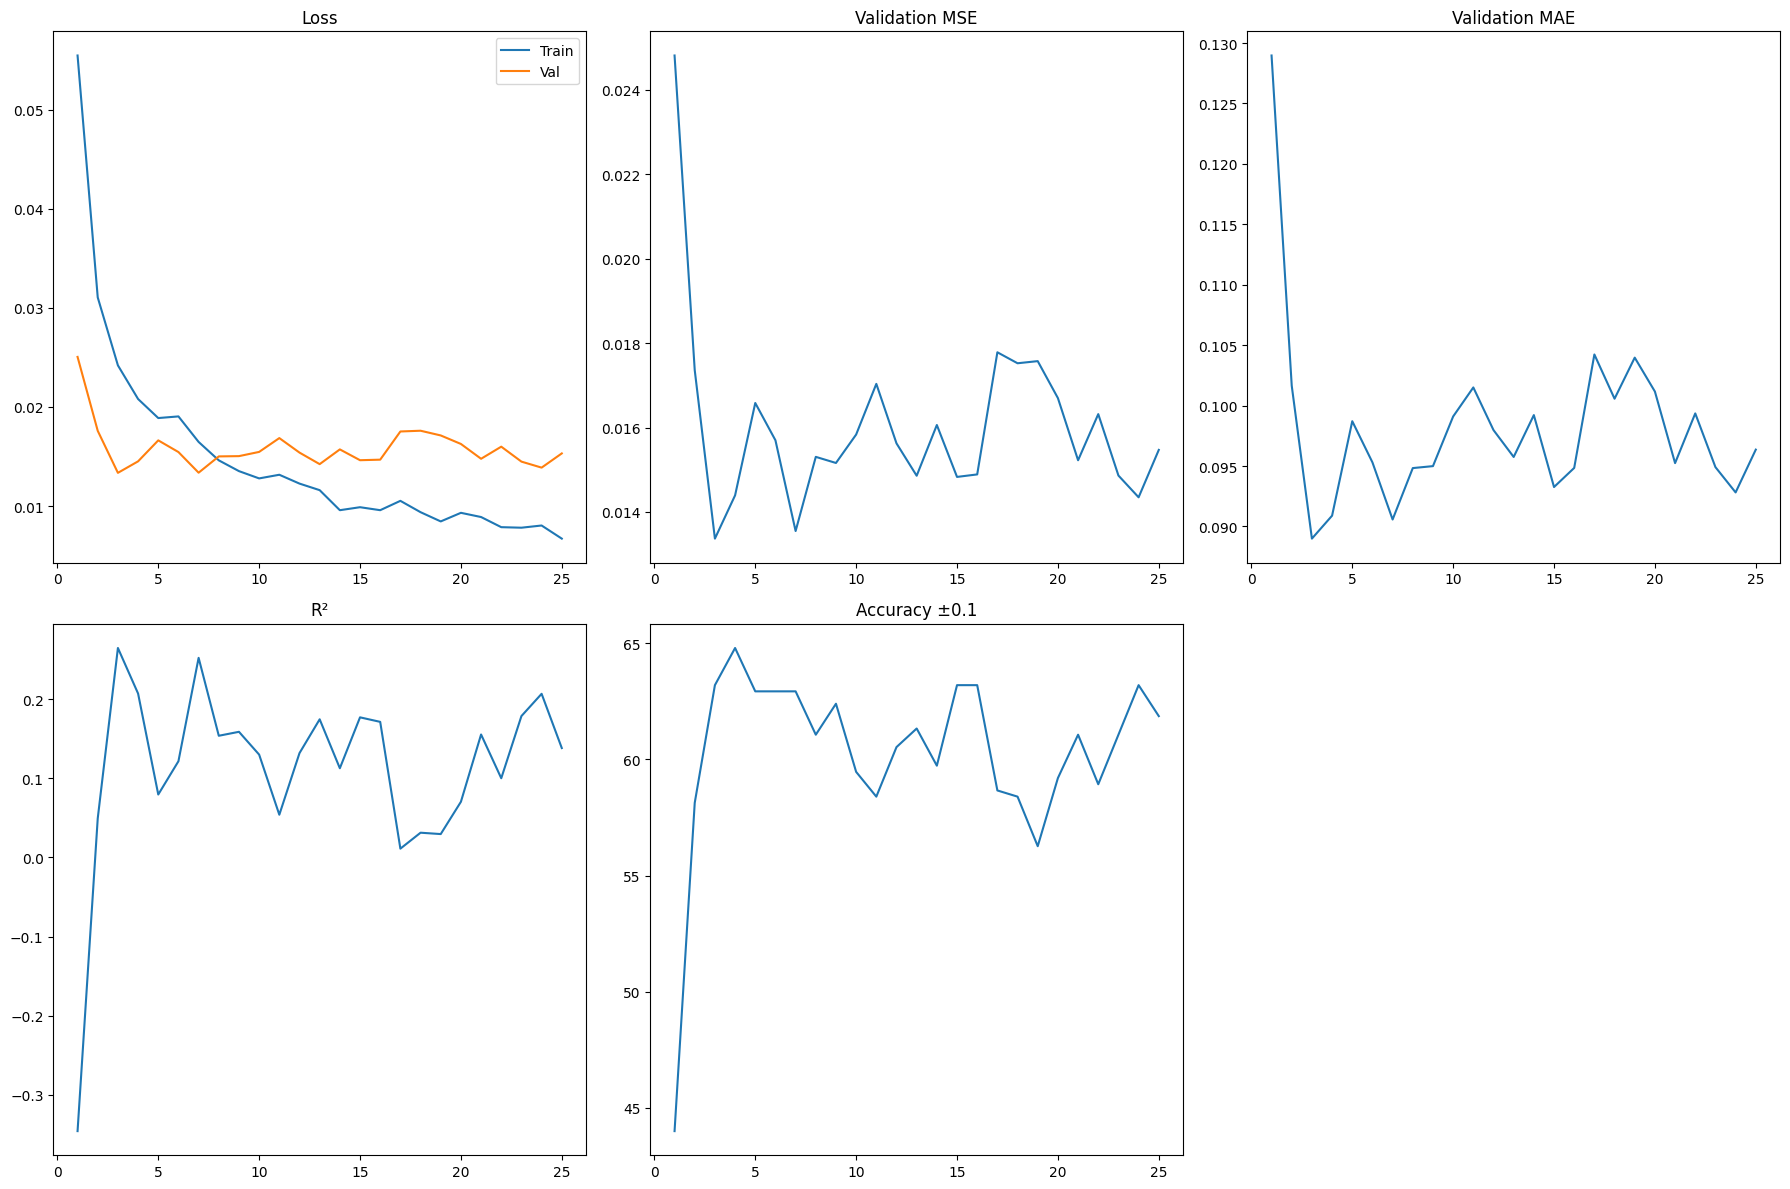


================= FINAL TEST RESULTS =================
MSE: 0.0192
MAE: 0.1061
R²:  0.1647
Accuracy ±0.1: 56.00%


In [ ]:
# ============================================================
# 📦 Install & Imports (BiLSTM + Transformer)
# ============================================================
!pip install -q scikit-learn

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# ============================================================
# 📂 Define Paths & Load Feature Files (UPDATED PATHS)
# ============================================================
# --- UPDATE FEATURE PATHS ---
# Based on your previous successful file combining:
FEATURE_DIR = "/content/drive/MyDrive/NNDL"
MODEL_SAVE_PATH = os.path.join(FEATURE_DIR, "best_bilstm_transformer.pth")

# The final combined 1000-row files, saved as 'first'
seq_X_path = os.path.join(FEATURE_DIR, "seq_X.npy")
seq_y_path = os.path.join(FEATURE_DIR, "seq_y.npy")
seq_id_path = os.path.join(FEATURE_DIR, "seq_id.npy")

print("Loading NPY feature files...")

try:
    # We load the final NPY files directly
    seq_X_raw = np.load(seq_X_path, allow_pickle=True)
    seq_y = np.load(seq_y_path)
    seq_id = np.load(seq_id_path)
except Exception as e:
    print(f"❌ Error loading NPY files: {e}. Check paths.")
    sys.exit()


# Ensure data is ready for the Dataset class
# X needs to be a list of arrays, y and id need to be arrays
seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
seq_y = np.array(seq_y, dtype=np.float32)
seq_id = np.array(seq_id)

N = len(seq_X)
INPUT_DIM = seq_X[0].shape[1] if N > 0 and seq_X[0].ndim == 2 else 0 # Safely get input dim

print(f"✅ Loaded {N} videos with INPUT_DIM={INPUT_DIM}")
print("Example X shape:", seq_X[0].shape)
print("Example y:", seq_y[0])
print("Example id:", seq_id[0])


# ============================================================
# 📦 Dataset + Collate fn (No change needed)
# ============================================================
class OceanDataset(Dataset):
    def __init__(self, X_list, y_array, ids):
        self.X_list = X_list
        self.y_array = y_array
        self.ids = ids

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        return {
            "x": torch.tensor(self.X_list[idx], dtype=torch.float32),
            "y": torch.tensor(self.y_array[idx], dtype=torch.float32),
            "id": self.ids[idx],
        }

def collate_fn(batch):
    xs = [item["x"] for item in batch]
    ys = [item["y"] for item in batch]
    ids = [item["id"] for item in batch]

    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    feat_dim = xs[0].shape[1]
    B = len(xs)

    padded_x = torch.zeros(B, max_len, feat_dim)
    mask = torch.zeros(B, max_len)

    for i, x in enumerate(xs):
        T = x.shape[0]
        padded_x[i, :T] = x
        mask[i, :T] = 1

    y = torch.stack(ys, dim=0)
    return {"x": padded_x, "y": y, "mask": mask, "id": ids}

dataset = OceanDataset(seq_X, seq_y, seq_id)


# ============================================================
# 📊 Train/Val/Test Split (No change needed)
# ============================================================
train_size = int(0.7 * N)
val_size = int(0.15 * N)
test_size = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


# ============================================================
# 🧠 Cross-Attention Block (No change needed)
# ============================================================
class CrossAttentionBlock(nn.Module):
    def __init__(self, dim, nhead=4, dropout=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(dim, nhead, dropout=dropout, batch_first=True)
        self.ln1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim*2),
            nn.ReLU(),
            nn.Linear(dim*2, dim)
        )
        self.ln2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, key_padding_mask=None):
        attn, _ = self.mha(q, k, v, key_padding_mask=key_padding_mask)
        x = self.ln1(q + self.dropout(attn))
        ff_out = self.ff(x)
        x = self.ln2(x + self.dropout(ff_out))
        return x


# ============================================================
# 🧠 BiLSTM + Transformer Multimodal Model (No change needed)
# ============================================================
class OceanBiLSTMTransformer(nn.Module):
    def __init__(self,
                 input_dim=1291,
                 clip_dim=512,
                 fer_dim=7,
                 wav_dim=768,
                 prosody_dim=4,
                 clip_enc_dim=128,
                 fer_enc_dim=32,
                 wav_enc_dim=128,
                 prosody_enc_dim=16,
                 d_model=256,
                 dropout=0.2,
                 nhead_xattn=4,
                 nhead_transformer=8,
                 num_layers_transformer=2):
        super().__init__()

        self.clip_dim = clip_dim
        self.fer_dim = fer_dim
        self.wav_dim = wav_dim
        self.prosody_dim = prosody_dim

        # ------------ Encoders -------------
        self.clip_encoder = nn.Sequential(
            nn.Linear(clip_dim, clip_enc_dim), nn.ReLU(), nn.LayerNorm(clip_enc_dim)
        )
        self.fer_encoder = nn.Sequential(
            nn.Linear(fer_dim, fer_enc_dim), nn.ReLU(), nn.LayerNorm(fer_enc_dim)
        )
        self.wav_encoder = nn.Sequential(
            nn.Linear(wav_dim, wav_enc_dim), nn.ReLU(), nn.LayerNorm(wav_enc_dim)
        )
        self.prosody_encoder = nn.Sequential(
            nn.Linear(prosody_dim, prosody_enc_dim), nn.ReLU(), nn.LayerNorm(prosody_enc_dim)
        )

        # ------------ Cross Attention -------------
        self.cross_clip_from_audio = CrossAttentionBlock(clip_enc_dim, nhead_xattn, dropout)
        self.cross_audio_from_clip = CrossAttentionBlock(wav_enc_dim, nhead_xattn, dropout)

        fused_dim = clip_enc_dim + wav_enc_dim + fer_enc_dim + prosody_enc_dim

        self.fuse_proj = nn.Sequential(
            nn.Linear(fused_dim, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
        )

        # ------------ BiLSTM -------------
        self.bilstm = nn.LSTM(
            d_model, d_model//2,
            batch_first=True,
            bidirectional=True
        )
        self.lstm_ln = nn.LayerNorm(d_model)

        # ------------ Transformer -------------
        self.cls_token = nn.Parameter(torch.randn(1,1,d_model))

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead_transformer,
            dim_feedforward=512, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers_transformer)

        # ------------ Regression Head -------------
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 5)
        )

    def forward(self, x, mask):
        B, T, D = x.shape

        # Split modalities
        x_clip = x[:, :, :self.clip_dim]
        x_fer = x[:, :, self.clip_dim:self.clip_dim+self.fer_dim]
        x_wav = x[:, :, self.clip_dim+self.fer_dim:self.clip_dim+self.fer_dim+self.wav_dim]
        x_pros = x[:, :, -self.prosody_dim:]

        # Encode
        e_clip = self.clip_encoder(x_clip)
        e_fer = self.fer_encoder(x_fer)
        e_wav = self.wav_encoder(x_wav)
        e_pros = self.prosody_encoder(x_pros)

        padding_mask = (mask==0)

        # Cross attention
        clip_ca = self.cross_clip_from_audio(e_clip, e_wav, e_wav, key_padding_mask=padding_mask)
        wav_ca = self.cross_audio_from_clip(e_wav, e_clip, e_clip, key_padding_mask=padding_mask)

        fused = torch.cat([clip_ca, wav_ca, e_fer, e_pros], dim=-1)
        fused = self.fuse_proj(fused)

        # BiLSTM
        lstm_out, _ = self.bilstm(fused)
        lstm_out = self.lstm_ln(lstm_out)

        # Transformer w/ CLS
        cls = self.cls_token.expand(B,1,-1)
        seq = torch.cat([cls, lstm_out], dim=1)

        full_mask = torch.cat([torch.ones(B,1,device=mask.device), mask], dim=1)
        key_mask = (full_mask==0)

        enc = self.encoder(seq, src_key_padding_mask=key_mask)
        out = enc[:,0]

        return self.head(out)


# ============================================================
# 📏 Metrics (No change needed)
# ============================================================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    acc = ((np.abs(y_true - y_pred) <= 0.1).mean()) * 100
    return mse, mae, r2, acc


# ============================================================
# 🏋️ Training (UPDATED: Added Model Saving)
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = OceanBiLSTMTransformer(input_dim=INPUT_DIM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

train_loss_history = []
val_loss_history = []
val_mse_history = []
val_mae_history = []
val_r2_history = []
val_acc_history = []

best_val = float("inf")
patience = 5
pat_ctr = 0
EPOCHS = 25

print(f"\nStarting training on {DEVICE}...")

for epoch in range(1, EPOCHS+1):

    model.train()
    train_losses = []

    for batch in train_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        optimizer.zero_grad()
        preds = model(x, mask)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train = np.mean(train_losses)
    train_loss_history.append(avg_train)

    # -------- Validation --------
    model.eval()
    val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

            preds = model(x, mask)
            loss = criterion(preds, y)

            val_losses.append(loss.item())

            y_true.append(y.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    avg_val = np.mean(val_losses)
    val_loss_history.append(avg_val)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    mse, mae, r2, acc = compute_metrics(y_true, y_pred)

    val_mse_history.append(mse)
    val_mae_history.append(mae)
    val_r2_history.append(r2)
    val_acc_history.append(acc)

    print(f"Epoch {epoch:02d} | Train {avg_train:.4f} | Val {avg_val:.4f} | "
          f"MSE {mse:.4f} | MAE {mae:.4f} | R² {r2:.4f} | Acc±0.1 {acc:.2f}%")

    # Early stopping and Model Saving
    if avg_val < best_val:
        best_val = avg_val
        best_state = model.state_dict()
        pat_ctr = 0
        torch.save(best_state, MODEL_SAVE_PATH) # SAVING THE BEST MODEL
        print(f"   💾 Model saved to {MODEL_SAVE_PATH}")


model.load_state_dict(best_state) # Load the best state found

# ============================================================
# 📈 Plot Metrics (No change needed)
# ============================================================
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(18, 12))

plt.subplot(2,3,1); plt.plot(epochs, train_loss_history, label='Train'); plt.plot(epochs, val_loss_history, label='Val'); plt.title("Loss"); plt.legend()
plt.subplot(2,3,2); plt.plot(epochs, val_mse_history); plt.title("Validation MSE")
plt.subplot(2,3,3); plt.plot(epochs, val_mae_history); plt.title("Validation MAE")
plt.subplot(2,3,4); plt.plot(epochs, val_r2_history); plt.title("R²")
plt.subplot(2,3,5); plt.plot(epochs, val_acc_history); plt.title("Accuracy ±0.1")

plt.tight_layout()
plt.show()


# ============================================================
# 🧪 Final Test Evaluation (No change needed)
# ============================================================
model.eval()
true_list, pred_list = [], []

with torch.no_grad():
    for batch in test_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
        preds = model(x, mask)

        true_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())

true_list = np.vstack(true_list)
pred_list = np.vstack(pred_list)

mse, mae, r2, acc = compute_metrics(true_list, pred_list)

print("\n================= FINAL TEST RESULTS =================")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")
print(f"Accuracy ±0.1: {acc:.2f}%")
print("======================================================")